In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, proj3d
from matplotlib.patches import FancyArrowPatch
from ipywidgets import interact, fixed
import ipywidgets as widgets

# Tutorial Table Rotations

## Helper Functions

We need the function plot_nb to visualize the body and navigation frames :

In [2]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs
    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

def plot_nb(Cnb, plotNframe=True):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.grid(False)
    lim = [-0.75, 0.75]
    ax.set_xlim3d(lim)
    ax.set_xticks([])
    ax.set_ylim3d(lim)
    ax.set_yticks([])
    ax.set_zlim3d(lim)
    ax.set_zticks([])
    plt.axis('off')
    
    # plot the navigation frame N in black 
    if plotNframe:
        z = [0, 0]
        xn = Arrow3D([0, 1], z, z, mutation_scale=20,
            lw=1, arrowstyle="-|>", color='k')
        ax.add_artist(xn)        
        yn = Arrow3D(z, [0, 1], z, mutation_scale=20,
            lw=1, arrowstyle="-|>", color='k')
        ax.add_artist(yn)            
        zn = Arrow3D(z, z, [0, 1], mutation_scale=20,
            lw=1, arrowstyle="-|>", color='k')
        ax.add_artist(zn)
    
    # plot the body frame B
    xb = Arrow3D([0,Cnb[0,0]], [0,Cnb[1,0]], [0,Cnb[2,0]], mutation_scale=20,
            lw=1, arrowstyle="-|>", color='b', label='$x_b$')
    ax.add_artist(xb)
    yb = Arrow3D([0,Cnb[0,1]], [0,Cnb[1,1]], [0,Cnb[2,1]], mutation_scale=20,
            lw=1, arrowstyle="-|>", color='orange', label='$y_b$')
    ax.add_artist(yb)
    zb = Arrow3D([0,Cnb[0,2]], [0,Cnb[1,2]], [0,Cnb[2,2]], mutation_scale=20,
            lw=1, arrowstyle="-|>", color='g', label='$z_b$')
    ax.add_artist(zb)
    
    plt.legend(handles=[xb,yb,zb]) 
    plt.show()

## Create a direction cosine matrix from heading, pitch and roll angles

By definition :
${C}_{nb} = \left[
\begin{array}{ccc}
\left[ \overrightarrow{x_b}\right]_{[n]} & \left[
\overrightarrow{y_b}\right]_{[n]} & \left[
\overrightarrow{z_b}\right]_{[n]}
\end{array}
\right].$ 

One way to define this matrix is the Euler angles, the convention chosen in PyINS is this sequence of elemental rotations as follows:

${\LARGE N \stackrel{\text{-heading}}{\longrightarrow}  \stackrel{\text{pitch}}  {\longrightarrow} \stackrel{\text{roll}}{\longrightarrow}}  \LARGE B$

Let's choose the heading, pitch and roll in degrees:

In [3]:
h = +30 # heading
p = 10  # pitch
r = -6  # roll

Compute and plot the direction cosine matrix **B**ody frame to **N**avigation frame :

In [4]:
from pyins import dcm

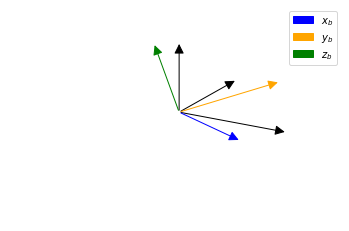

In [5]:
Cnb = dcm.from_hpr(h, p, r)
plot_nb(Cnb)

## Use of the 3-axis turntable 

Selection of a 100Hz frequency : 

In [6]:
dt = 1/100

### Creating a sequence

Select $N = B$ to start :

In [7]:
h0, p0, r0 = 0, 0, 0 

Calling the TableRotations object, by default the rest time is 20 seconds and the speed of rotation is 10 °/s

In [8]:
from pyins import sim

In [9]:
Table = sim.TableRotations(dt, h0, p0, r0)

We start with an rest of 5s :

In [10]:
Table.rest(5)

Then a 90° rotation around $x_n$ at the default rotation speed :

In [11]:
Table.rotate(0, 90)

Then a default rest:

In [12]:
Table.rest()

Then a -90° rotation around $y_n$ at 20°/s :

In [13]:
Table.rotate(1, -90, 20)

Then a default rest:

In [14]:
Table.rest()

Then a 90° rotation around $z_n$ at the default rotation speed :

In [15]:
Table.rotate(2, 90)

Then a default rest:

In [16]:
Table.rest()

And so on... Next time, we'll do a loop for !

We can visualize the sequence thanks to Jupiter's interact function :

In [17]:
def f(t_s, dt, Cnb):
    n = int(t_s/dt)
    plot_nb(Cnb[n,:,:])
    
tf = Table.Cnb.shape[0]*dt
interact(f, t_s = widgets.FloatSlider(value=0, min=0, max=tf, step=1), Cnb = fixed(Table.Cnb), dt = fixed(dt))

interactive(children=(FloatSlider(value=0.0, description='t_s', max=87.51, step=1.0), Output()), _dom_classes=…

<function __main__.f(t_s, dt, Cnb)>

### Generate inertial readings

We have to choose the position of the table e.g. Paris :

In [18]:
lat_Paris = 48.8534  # degrees
#lon_Paris = 2.3488  # degrees (Longitude doesn't matter here, the earth is modeled by an ellipsoid of revolution.)
alt_Paris = 35       # meters

Then we generate the inertial measurements :

In [19]:
gyros, accels = sim.stationary_rotation(dt, lat_Paris, alt_Paris, Table.Cnb)

The inertial readings are drawn below:

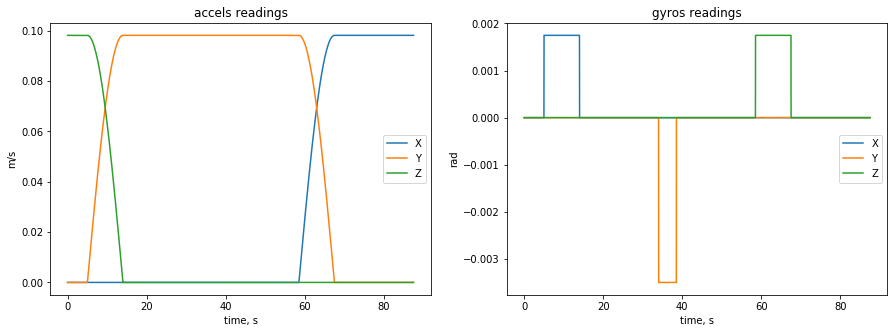

In [20]:
def plot_inertial_readings(dt, gyros, accels, step=1):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    n = accels.shape[0]
    t =  dt * np.arange(n)
    
    ax1.plot(t[::step], accels[::step])
    ax1.legend(['X','Y','Z'], loc='center right')
    ax1.set_xlabel('time, s')
    ax1.set_title('accels readings')
    ax1.set_ylabel('m/s')
    
    ax2.plot(t[::step], gyros[::step])
    ax2.legend(['X','Y','Z'], loc='center right')
    ax2.set_xlabel('time, s')
    ax2.set_title('gyros readings')
    ax2.set_ylabel('rad')

    plt.show()

plot_inertial_readings(dt, gyros, accels)